In [26]:
import tensorflow as tf
import pickle
import numpy as np
import os
from tensorflow.keras.preprocessing.image import img_to_array
import tensorflow as tf
from tensorflow.keras import layers, models


In [27]:
print(f"Tensor flow version: {tf.__version__}")

Tensor flow version: 2.10.0


## 1. Preparación de los datos

### Descargar el conjunto de datos de rótulos de tráfico que contiene las imágenes de las 43 clases mencionadas

In [28]:
# Cargar el archivo .p
with open('data/Datos_Rotulos_Trafico/entrenamiento.p', 'rb') as file:
    data = pickle.load(file)

# Imprimir las claves disponibles
print(data.keys())

# Inspeccionar un poco más el contenido
for key in data.keys():
    print(f"Key: {key}, Type: {type(data[key])}, Length: {len(data[key])}")


dict_keys(['coords', 'labels', 'features', 'sizes'])
Key: coords, Type: <class 'numpy.ndarray'>, Length: 34799
Key: labels, Type: <class 'numpy.ndarray'>, Length: 34799
Key: features, Type: <class 'numpy.ndarray'>, Length: 34799
Key: sizes, Type: <class 'numpy.ndarray'>, Length: 34799


### Dividir el conjunto de datos en conjuntos de entrenamiento, validación y prueba.

In [29]:
# Función para cargar los datos desde un archivo .p
def load_data(pickle_file):
    with open(pickle_file, 'rb') as file:
        data = pickle.load(file)
    return data['features'], data['labels']

In [30]:
# Cargar los conjuntos de datos
X_train, y_train = load_data('data/Datos_Rotulos_Trafico/entrenamiento.p')
X_val, y_val = load_data('data/Datos_Rotulos_Trafico/validacion.p')
X_test, y_test = load_data('data/Datos_Rotulos_Trafico/prueba.p')


### Realizar preprocesamiento de las imágenes, como redimensionarlas a un tamaño estándar, normalización, etc

In [31]:
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

# Convertir etiquetas a arrays de NumPy (aunque ya están en ese formato, es bueno asegurarse)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [32]:
# Verificar la forma de los datos
print(f'Train data shape: {X_train.shape}, Labels shape: {y_train.shape}')
print(f'Validation data shape: {X_val.shape}, Labels shape: {y_val.shape}')
print(f'Test data shape: {X_test.shape}, Labels shape: {y_test.shape}')

Train data shape: (34799, 32, 32, 3), Labels shape: (34799,)
Validation data shape: (4410, 32, 32, 3), Labels shape: (4410,)
Test data shape: (12630, 32, 32, 3), Labels shape: (12630,)


## 2. Implementación de la arquitectura Le-Net:

### Presentar la arquitectura Le-Net en detalle, explicando cada capa (convolucional, pooling, fully connected).

LeNet es una de las primeras arquitecturas de redes neuronales convolucionales, desarrollada por Yann LeCun y su equipo en 1998. Fue diseñada inicialmente para reconocer dígitos escritos a mano en imágenes de 28x28 píxeles, como los dígitos del conjunto de datos MNIST. A continuación, se detalla la arquitectura de LeNet:

#### 1. Capa Convolucional 1 (Conv1)
- **Entrada**: Una imagen de 32x32 píxeles (en blanco y negro, con un solo canal).
- **Operación**: Se aplica un filtro convolucional de tamaño 5x5, con 6 filtros en total, produciendo 6 mapas de características.
- **Salida**: 6 mapas de características, cada uno de tamaño 28x28 píxeles.

#### 2. Capa de Submuestreo (Pooling) 1 (Pool1)
- **Entrada**: Los 6 mapas de características de la capa anterior.
- **Operación**: Se aplica un max-pooling (o submuestreo) con un tamaño de ventana 2x2 y un stride de 2, lo que reduce las dimensiones de cada mapa de características.
- **Salida**: 6 mapas de características de tamaño 14x14 píxeles.

#### 3. Capa Convolucional 2 (Conv2)
- **Entrada**: Los 6 mapas de características de la capa anterior.
- **Operación**: Se aplican 16 filtros convolucionales de tamaño 5x5, produciendo 16 nuevos mapas de características.
- **Salida**: 16 mapas de características, cada uno de tamaño 10x10 píxeles.

#### 4. Capa de Submuestreo (Pooling) 2 (Pool2)
- **Entrada**: Los 16 mapas de características de la capa anterior.
- **Operación**: Se aplica max-pooling con una ventana de 2x2 y un stride de 2.
- **Salida**: 16 mapas de características de tamaño 5x5 píxeles.

#### 5. Capa Fully Connected (FC1)
- **Entrada**: Las salidas aplanadas de los 16 mapas de características de tamaño 5x5, lo que da un vector de 400 elementos (16x5x5).
- **Operación**: Se conecta cada una de las 400 entradas a 120 neuronas completamente conectadas.
- **Salida**: Un vector de 120 elementos.

#### 6. Capa Fully Connected (FC2)
- **Entrada**: El vector de 120 elementos de la capa anterior.
- **Operación**: Se conecta cada uno de los 120 valores a 84 neuronas completamente conectadas.
- **Salida**: Un vector de 84 elementos.

#### 7. Capa de Salida (Output Layer)
- **Entrada**: El vector de 84 elementos.
- **Operación**: Se conecta a una capa de salida con tantas neuronas como clases de salida, en este caso 10 (para los dígitos del 0 al 9 en MNIST).
- **Salida**: Un vector de 10 elementos, que representa las probabilidades de pertenencia a cada clase.

En resumen, la arquitectura LeNet es un ejemplo clásico de una red neuronal convolucional, que combina capas convolucionales para extracción de características y capas completamente conectadas para la clasificación. Aunque sencilla en comparación con arquitecturas modernas, LeNet sentó las bases para muchos avances en el campo de la visión por computadora.


### Mostrar el diseño de la red Le-Net utilizando una herramienta de diagramación.

![Diagrama en blanco.png](<attachment:Diagrama en blanco.png>)
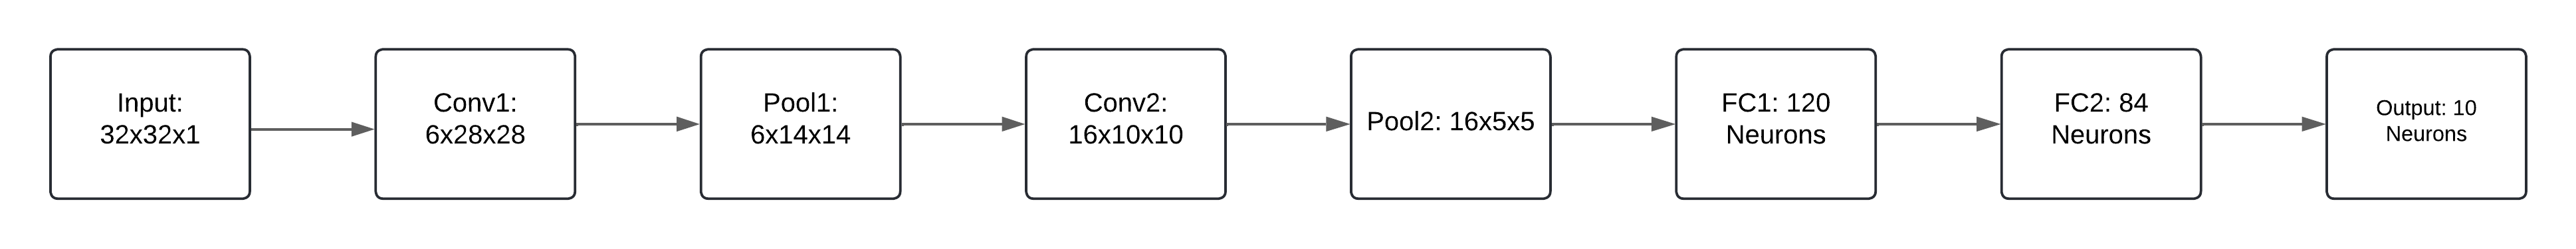

La red LeNet toma como entrada una imagen de 32x32 píxeles y la procesa a través de varias capas para extraer características y clasificarlas. El flujo de la red es el siguiente:

1. **Input Layer**: Recibe la imagen de entrada de 32x32 píxeles con un solo canal (en blanco y negro).

2. **Conv1 Layer**: Aplica 6 filtros convolucionales de tamaño 5x5 para generar 6 mapas de características, cada uno de 28x28 píxeles.

3. **Pool1 Layer**: Realiza una operación de submuestreo (pooling) para reducir el tamaño de los mapas de características a 14x14 píxeles.

4. **Conv2 Layer**: Aplica 16 filtros convolucionales de tamaño 5x5, produciendo 16 mapas de características de 10x10 píxeles.

5. **Pool2 Layer**: Aplica otro submuestreo para reducir el tamaño de los mapas de características a 5x5 píxeles.

6. **FC1 Layer**: Aplana las características y las pasa a través de una capa completamente conectada con 120 neuronas.

7. **FC2 Layer**: Las salidas de la capa anterior se pasan a otra capa completamente conectada con 84 neuronas.

8. **Output Layer**: Finalmente, la capa de salida consiste en 10 neuronas, que corresponden a las 10 clases posibles para la clasificación.

Este flujo de procesamiento permite que la red LeNet extraiga y combine características a diferentes niveles de abstracción, culminando en la predicción de la clase de la imagen de entrada.


### Explicar el proceso de convolución, función de activación y pooling.

**Proceso de Convolución**

El proceso de convolución es una operación fundamental en las redes neuronales convolucionales (CNNs) que consiste en aplicar un filtro (o kernel) sobre la entrada (como una imagen) para extraer características importantes. El filtro se desliza (o convoluciona) sobre la entrada, realizando multiplicaciones punto a punto entre los valores del filtro y las secciones correspondientes de la imagen. Luego, se suman los productos resultantes para obtener un solo valor que representa la activación en esa ubicación específica. Este proceso se repite para cada posición del filtro, produciendo un mapa de características que resalta las características detectadas por el filtro en la imagen original.

**Función de Activación**

Una vez que la convolución se ha aplicado, el resultado suele pasar a través de una función de activación, siendo la más común la función ReLU (Rectified Linear Unit). La función ReLU se define como \( f(x) = \max(0, x) \), es decir, reemplaza todos los valores negativos por cero y deja los valores positivos sin cambios. Esta no linealidad permite a la red aprender una amplia gama de patrones complejos y aumentar su capacidad de representación. La función de activación se aplica a cada valor en el mapa de características generado por la convolución.

**Pooling**

El pooling es una operación de reducción de dimensionalidad que se aplica sobre los mapas de características después de la convolución y la activación. La operación más común es el Max Pooling, donde se selecciona el valor máximo dentro de una ventana (por ejemplo, de 2x2) que se desliza sobre el mapa de características. El pooling reduce el tamaño del mapa de características, haciendo que la red sea más computacionalmente eficiente y menos propensa a sobreajustarse. También ayuda a que la red sea invariante a pequeñas traslaciones de la entrada, mejorando la capacidad de generalización del modelo.


## 3. Construcción del modelo:

### Utilizar la biblioteca de aprendizaje profundo TensorFlow para construir la arquitectura Le-Net

In [34]:
model = models.Sequential()

### Definir la estructura de capas convolucionales, capas de pooling y capas fully connected.

In [35]:
# Capa Convolucional 1
model.add(layers.Conv2D(6, (5, 5), activation='relu', input_shape=(32, 32, 1)))
model.add(layers.MaxPooling2D((2, 2)))

# Capa Convolucional 2
model.add(layers.Conv2D(16, (5, 5), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Aplanar las características
model.add(layers.Flatten())

# Capa Fully Connected 1
model.add(layers.Dense(120, activation='relu'))

# Capa Fully Connected 2
model.add(layers.Dense(84, activation='relu'))

# Capa de Salida
model.add(layers.Dense(10, activation='softmax'))

In [36]:
# Resumen del modelo
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 6)         156       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 6)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 400)               0         
                                                                 
 dense_6 (Dense)             (None, 120)              

### Explicar la importancia de la función de pérdida y el optimizador.

**Función de Pérdida**

La función de pérdida es un componente crucial en el entrenamiento de una red neuronal. Su principal objetivo es cuantificar cuán lejos están las predicciones del modelo de las verdaderas etiquetas. En otras palabras, mide el "costo" o "error" asociado a las predicciones actuales de la red. Durante el entrenamiento, el modelo intenta minimizar esta función de pérdida, ajustando los pesos de la red para que las predicciones se acerquen lo más posible a las etiquetas correctas. Existen diferentes tipos de funciones de pérdida, como la entropía cruzada para tareas de clasificación o el error cuadrático medio para tareas de regresión, cada una adecuada para diferentes tipos de problemas.

**Optimizador**

El optimizador es el algoritmo que ajusta los pesos y sesgos de la red neuronal en función del valor de la función de pérdida. Su papel es minimizar la función de pérdida mediante un proceso iterativo de ajuste de los parámetros del modelo. Uno de los optimizadores más comunes es el Descenso de Gradiente Estocástico (SGD), que ajusta los parámetros en la dirección opuesta al gradiente de la función de pérdida con respecto a los parámetros. Variantes más avanzadas como Adam, RMSprop, y AdaGrad, entre otros, incluyen mejoras para manejar la velocidad de aprendizaje de manera adaptativa y reducir la variabilidad del descenso de gradiente, acelerando así la convergencia y mejorando la estabilidad del entrenamiento.

**Importancia Conjunta**

La combinación de una función de pérdida y un optimizador es fundamental para el entrenamiento efectivo de una red neuronal. Mientras que la función de pérdida proporciona una medida del error que el modelo debe minimizar, el optimizador determina cómo el modelo debe actualizar sus pesos para reducir ese error. Juntos, estos componentes permiten que la red aprenda patrones complejos en los datos, mejorando su capacidad para hacer predicciones precisas.
